# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pr9082t5
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pr9082t5
  Resolved https://github.com/albumentations-team/albumentations to commit 3363e0ab152c9d8910a9e7777ebb08056e1f53b3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


Dataset for disaster segmentaition https://drive.google.com/drive/folders/1sZZMJkbqJNbHgebKvHzcXYZHJd6ss4tH

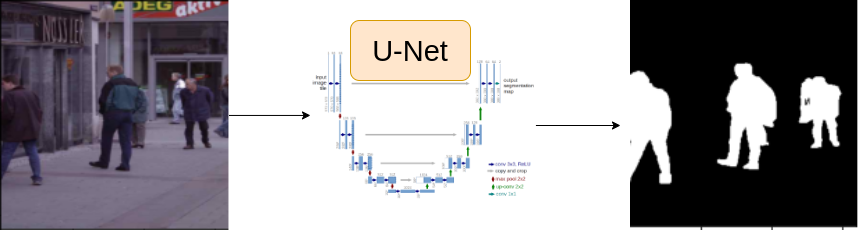

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

device = 'cuda'

EPOCHS  =25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[5]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

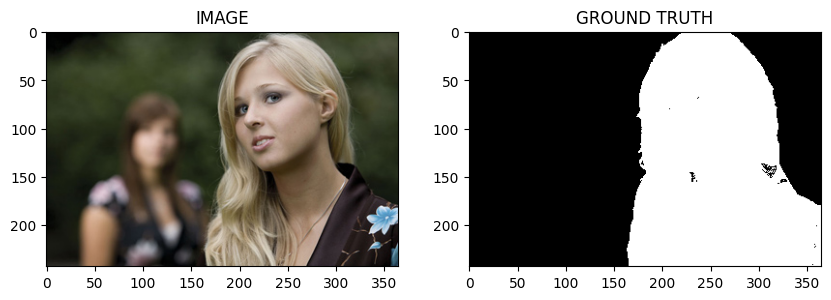

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p=0.5),
  ],      is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)

      ],  is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from os import MFD_HUGE_MASK
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  # now a feature for geting the item by its index
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      # current format is (h,w,c) and we will change t to (c, h, w)

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

#

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


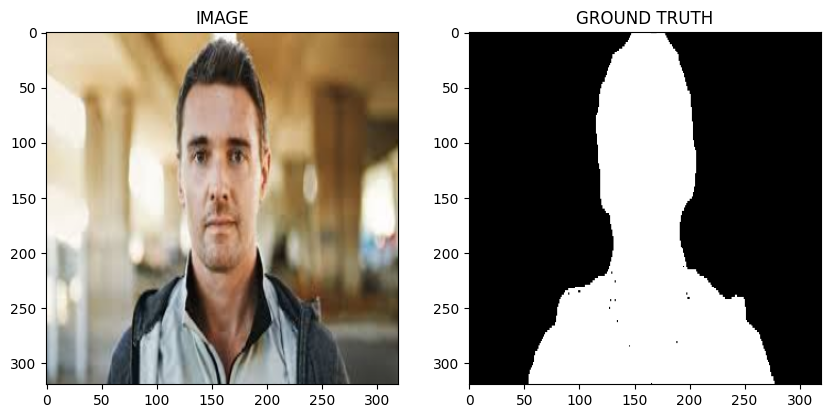

In [ ]:
idx = 32
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"total no. of trainloader : {len(trainloader)}")
print(f"total no. of validloader : {len(validloader)}")

total no. of trainloader : 15
total no. of validloader : 4


In [ ]:
for image,mask in trainloader:
  break
  # print(mask)
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape: {mask.shape}")


One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_chanels = 3,
        classes = 1,
        activation = None
    )


  def forward(self, images, masks = None):
    logits = self.arc(images)


    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [ ]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model,optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)



In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)
      optimizer.step()

      total_loss += loss.item()

  return total_loss/len(data_loader)



# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf


for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Best Model!")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")

100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Saved Best Model!
Epoch : 1
Train Loss : 0.8111
Valid Loss : 0.6601


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 2
Train Loss : 0.7621
Valid Loss : 3.9517


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 3
Train Loss : 0.5616
Valid Loss : 1.0698


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Saved Best Model!
Epoch : 4
Train Loss : 0.4805
Valid Loss : 0.5048


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch : 5
Train Loss : 0.5933
Valid Loss : 0.6547


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Saved Best Model!
Epoch : 6
Train Loss : 0.4301
Valid Loss : 0.4334


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Saved Best Model!
Epoch : 7
Train Loss : 0.4474
Valid Loss : 0.3586


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 8
Train Loss : 0.4210
Valid Loss : 0.5196


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 9
Train Loss : 0.4367
Valid Loss : 0.3675


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Saved Best Model!
Epoch : 10
Train Loss : 0.3616
Valid Loss : 0.2637


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


Epoch : 11
Train Loss : 0.3006
Valid Loss : 0.3819


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Saved Best Model!
Epoch : 12
Train Loss : 0.2539
Valid Loss : 0.2273


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch : 13
Train Loss : 0.2992
Valid Loss : 0.3757


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Epoch : 14
Train Loss : 0.4201
Valid Loss : 0.4499


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch : 15
Train Loss : 0.3742
Valid Loss : 0.3335


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 16
Train Loss : 0.3552
Valid Loss : 0.3426


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 17
Train Loss : 0.3991
Valid Loss : 0.4287


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 18
Train Loss : 0.5121
Valid Loss : 0.3824


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 19
Train Loss : 0.4523
Valid Loss : 0.4678


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 20
Train Loss : 0.3219
Valid Loss : 0.3016


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 21
Train Loss : 0.2730
Valid Loss : 0.3004


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 22
Train Loss : 0.2939
Valid Loss : 0.2669


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 23
Train Loss : 0.2421
Valid Loss : 0.2496


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch : 24
Train Loss : 0.3230
Valid Loss : 0.3915


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

Epoch : 25
Train Loss : 0.3092
Valid Loss : 0.2894


# Task 9 : Inference

In [ ]:
idx = 46

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
print((image.to(device).unsqueeze(0)).shape)
logits_mask = model((image.to(device)).unsqueeze(0))
# the above code transformed c, h, w -> 1, c, h, w
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask >= 0.5)*1.0

torch.Size([1, 3, 320, 320])


<ipython-input-115-da4e5dc08906>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


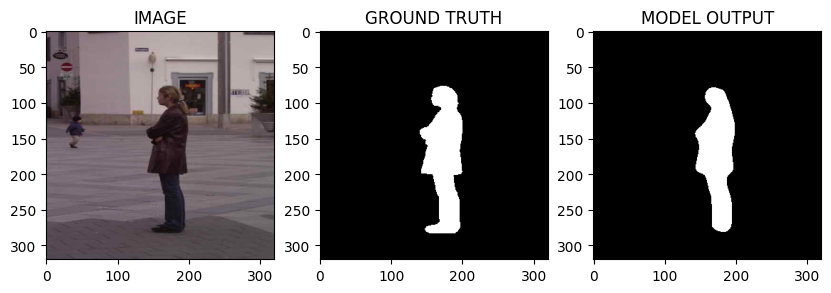

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya